In [42]:
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
from konlpy.tag import Mecab
from transformers import TFDistilBertModel, DistilBertTokenizer

## 데이터 준비

In [43]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 로더

In [44]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = [ '', '', '',''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [45]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 가공

In [46]:
# Correctly assign special tokens in word_to_index
word_to_index['<PAD>'] = 0  # 패딩용 단어
word_to_index['<BOS>'] = 1  # 문장의 시작지점
word_to_index['<UNK>'] = 2  # 사전에 없는(Unknown) 단어
word_to_index['<UNUSED>'] = 3

# Now reverse the word_to_index dictionary into index_to_word
index_to_word = {index: word for word, index in word_to_index.items()}

# Testing: This should now print '<BOS>' for index 1 and a common word for index 4 (if present)
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[3])     


print(get_decoded_sentence(X_train[0], index_to_word))


<BOS>
<UNUSED>
더 빙 . . 진짜 짜증 나 네요 목소리


In [47]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [48]:

print(f"훈련 샘플 개수: {len(X_train)}, 테스트 개수: {len(X_test)}")

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [49]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [50]:
# 문장 길이 분포 분석
train_lengths = [len(seq) for seq in X_train]
test_lengths = [len(seq) for seq in X_test]
all_lengths = train_lengths + test_lengths
max_length = max(all_lengths)

print(f"문장 길이 분포: 최소 {min(all_lengths)}, 최대 {max(all_lengths)}, 평균 {np.mean(all_lengths)}")
print(f"적절한 최대 문장 길이: {max_length}")


문장 길이 분포: 최소 0, 최대 116, 평균 15.96940191154864
적절한 최대 문장 길이: 116


In [51]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [52]:

# 패딩을 적용할 때 '<PAD>' 토큰의 인덱스를 사용
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)


(146182, 41)


## 모델 구성 및 validation set 구성

In [70]:
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, Dense, GRU, GlobalMaxPooling1D,SimpleRNN
#철희 cnn + rnn
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# 모델 설계
rnn_cnn = tf.keras.Sequential()

# Embedding Layer
rnn_cnn.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, input_length=maxlen))

# RNN Layer
rnn_cnn.add(SimpleRNN(64, return_sequences=True))  # RNN의 출력으로 시퀀스를 반환하도록 설정

# Conv1D Layer
rnn_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Global Max Pooling
rnn_cnn.add(GlobalMaxPooling1D())

# Dense Layers
rnn_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
rnn_cnn.add(tf.keras.layers.Dense(32, activation='relu'))
rnn_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# 모델 요약 출력
rnn_cnn.summary()


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 41, 16)            160000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 41, 64)            5184      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 37, 64)            20544     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [76]:
## GRU

# GRU 모델 설계
model_gru = tf.keras.Sequential()

# Embedding Layer
model_gru.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim))

# GRU Layer
model_gru.add(tf.keras.layers.GRU(64))  # 64는 GRU 유닛 수 (하이퍼파라미터로 조정 가능)

# Dense Layers
model_gru.add(tf.keras.layers.Dense(64, activation='relu'))
model_gru.add(tf.keras.layers.Dense(32, activation='relu'))
model_gru.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gru.summary()


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
gru_12 (GRU)                 (None, 64)                15744     
_________________________________________________________________
dense_32 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 33        
Total params: 182,017
Trainable params: 182,017
Non-trainable params: 0
_________________________________________________________________


In [78]:
## bi-lstm 

model_bi_lstm = tf.keras.Sequential()

## Embedding layer
model_bi_lstm.add(tf.keras.layers.Embedding(input_dim=vocab_size, output_dim = word_vector_dim))

## bi_lstm layer
model_bi_lstm.add(tf.keras.layers.Dense(64, activation = 'relu'))
model_bi_lstm.add(tf.keras.layers.Dense(32, activation = 'relu'))
model_bi_lstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_bi_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
dense_36 (Dense)             (None, None, 64)          1088      
_________________________________________________________________
dense_37 (Dense)             (None, None, 32)          2080      
_________________________________________________________________
dense_38 (Dense)             (None, None, 1)           33        
Total params: 163,201
Trainable params: 163,201
Non-trainable params: 0
_________________________________________________________________


In [20]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 훈련 개시

In [71]:
rnn_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

rnn_cnn_history = rnn_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 11s 38ms/step - loss: 0.4434 - accuracy: 0.7769 - val_loss: 0.3492 - val_accuracy: 0.8481
Epoch 2/20
266/266 [==============================] - 10s 37ms/step - loss: 0.3221 - accuracy: 0.8623 - val_loss: 0.3317 - val_accuracy: 0.8541
Epoch 3/20
266/266 [==============================] - 10s 38ms/step - loss: 0.2824 - accuracy: 0.8830 - val_loss: 0.3349 - val_accuracy: 0.8550
Epoch 4/20
266/266 [==============================] - 10s 37ms/step - loss: 0.2460 - accuracy: 0.9003 - val_loss: 0.3492 - val_accuracy: 0.8528
Epoch 5/20
266/266 [==============================] - 10s 37ms/step - loss: 0.2099 - accuracy: 0.9170 - val_loss: 0.3931 - val_accuracy: 0.8438
Epoch 6/20
266/266 [==============================] - 10s 37ms/step - loss: 0.1779 - accuracy: 0.9318 - val_loss: 0.4247 - val_accuracy: 0.8452
Epoch 7/20
266/266 [==============================] - 10s 37ms/step - loss: 0.1510 - accuracy: 0.9438 - val_loss: 0.4768 - val_accuracy:

In [73]:
rnn_cnn_results = rnn_cnn.evaluate(X_test,  y_test, verbose=2)

print(rnn_cnn_results)

1537/1537 - 7s - loss: 0.9497 - accuracy: 0.8234
[0.9497001767158508, 0.8233821988105774]


In [79]:
## gru
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

gru_history = model_gru.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 4s 7ms/step - loss: 0.4317 - accuracy: 0.7946 - val_loss: 0.3479 - val_accuracy: 0.8492
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3338 - accuracy: 0.8588 - val_loss: 0.3416 - val_accuracy: 0.8530
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3196 - accuracy: 0.8652 - val_loss: 0.3522 - val_accuracy: 0.8455
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3060 - accuracy: 0.8726 - val_loss: 0.3343 - val_accuracy: 0.8542
Epoch 5/20
266/266 [==============================] - 1s 6ms/step - loss: 0.2878 - accuracy: 0.8797 - val_loss: 0.3280 - val_accuracy: 0.8581
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2677 - accuracy: 0.8888 - val_loss: 0.3338 - val_accuracy: 0.8589
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2501 - accuracy: 0.8971 - val_loss: 0.3336 - val_accuracy: 0.8577
Epoch 

In [80]:
gru_results = model_gru.evaluate(X_test,  y_test, verbose=2)

print(gru_results)

1537/1537 - 3s - loss: 0.5850 - accuracy: 0.8388
[0.5850167274475098, 0.8388225436210632]


In [81]:
## bi-lstm

model_bi_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 20

model_bi_lstm_history = model_bi_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 5ms/step - loss: 0.6794 - accuracy: 0.5380 - val_loss: 0.6740 - val_accuracy: 0.5437
Epoch 2/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6733 - accuracy: 0.5438 - val_loss: 0.6740 - val_accuracy: 0.5428
Epoch 3/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6730 - accuracy: 0.5424 - val_loss: 0.6736 - val_accuracy: 0.5396
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.6728 - accuracy: 0.5430 - val_loss: 0.6738 - val_accuracy: 0.5394
Epoch 5/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6726 - accuracy: 0.5442 - val_loss: 0.6739 - val_accuracy: 0.5443
Epoch 6/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6725 - accuracy: 0.5441 - val_loss: 0.6739 - val_accuracy: 0.5394
Epoch 7/20
266/266 [==============================] - 1s 4ms/step - loss: 0.6724 - accuracy: 0.5445 - val_loss: 0.6737 - val_accuracy: 0.5446
Epoch 

In [82]:
bi_lstm_results = model_bi_lstm.evaluate(X_test,  y_test, verbose=2)

## layer를 단순하게 쌓아서 bi-lstm의 성능은 다른것 보다 훨씬 낮게 나옴 
print(bi_lstm_results)

1537/1537 - 3s - loss: 0.6743 - accuracy: 0.5361
[0.674333930015564, 0.5360787510871887]


## Loss, Accuracy 그래프 시각화

In [38]:
## model_word2_gru 

def training_visual_fun(history):
    history_dict = history.history
    print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

    import matplotlib.pyplot as plt

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo"는 "파란색 점"입니다
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b는 "파란 실선"입니다
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    plt.clf()   # 그림을 초기화합니다

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


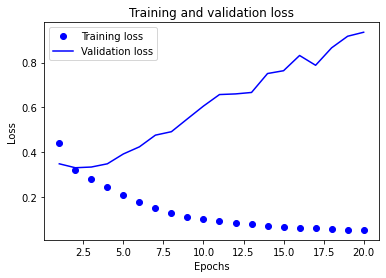

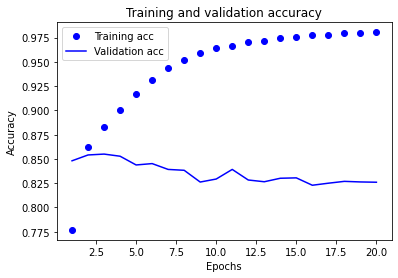

In [74]:
## rnn graph 
training_visual_fun(rnn_cnn_history)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


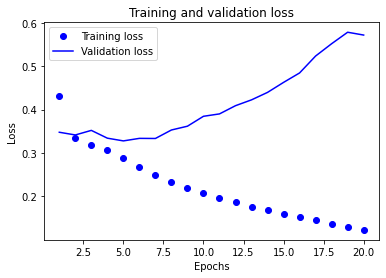

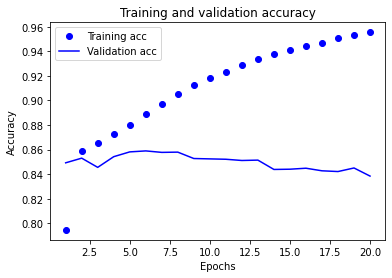

In [83]:
## gru graph
training_visual_fun(gru_history)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


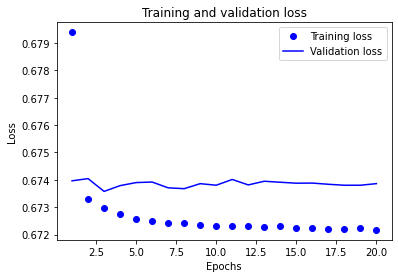

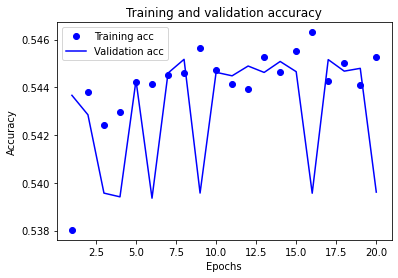

In [84]:
## bi-lstm graph
training_visual_fun(model_bi_lstm_history)

## 학습된 Embedding 레이어 분석

In [14]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant
import os

In [15]:
embedding_layer = model_gru.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [85]:
word2vec_file_path = os.getenv('HOME') + '/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [105]:
vocab_size, word_vector_dim = weights.shape

In [106]:
# Save word vectors in text format
word2vec_file_path = os.getenv('HOME') + '/aiffel/sentiment_classification/data/word2vec.txt'
with open(word2vec_file_path, 'w') as f:
    # Write header
    f.write(f'{vocab_size-4} {word_vector_dim}\n')  # Excluding special characters (4)

    # Write word vectors
    for i in range(4, vocab_size):
        vector_str = ' '.join(map(str, weights[i]))
        f.write(f'{index_to_word[i]} {vector_str}\n')

In [107]:
# Load the word2vec model from the text file
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [108]:
# Test with a sample word vector
vector = word_vectors['컴퓨터']
print(vector)

[-0.01218949 -0.01249907 -0.02062918  0.1087789   0.04511596  0.06844802
  0.10844214  0.02444657  0.16145709 -0.01693981  0.09117778  0.01697042
 -0.10961835  0.05780992 -0.0015825   0.0028042 ]


In [112]:
word_vectors.similar_by_word("컴퓨터", topn=10) 

[('소원', 0.8269624710083008),
 ('력', 0.8263224363327026),
 ('역동', 0.825524091720581),
 ('라면서', 0.8177840709686279),
 ('성형', 0.8098635673522949),
 ('내릴', 0.8021910190582275),
 ('셔야', 0.7920616269111633),
 ('기계', 0.7909428477287292),
 ('벼', 0.7876726984977722),
 ('정식', 0.7866978645324707)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [88]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[[index_to_word[i]]]

In [89]:
from keras.layers import GRU, LSTM, Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D, BatchNormalization, Bidirectional
# GRU + Bi-LSTM 모델 설계
model_bi_lstm_gru = tf.keras.Sequential()

# Embedding Layer
model_bi_lstm_gru.add(Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))  ## 사전 훈련된 모델 fine-tunning


# Conv1D Layer -> text에서 공간적인 정보는 필요없을 거 같아서 Conv1D로 설정 
model_bi_lstm_gru.add(Conv1D(filters=64, kernel_size=5, activation='relu'))

# Bi-LSTM Layer -> 단순히 GRU만으로 설계했을 때 dropout 때문인지 85를 넘기지 못해서 양방향으로 읽게 함 
## lstm에서 각 timestamp에 대한 정보가 다음 layer에 필요할 것 같아서 return_sequence = True로 설정 
model_bi_lstm_gru.add(Bidirectional(LSTM(64, return_sequences=True)))  

# GRU Layer
model_bi_lstm_gru.add(GRU(32, return_sequences= True))  # GRU Layer 
model_bi_lstm_gru.add(Dropout(0.3))  # Dropout 추가

# Batch Normalization
model_bi_lstm_gru.add(BatchNormalization())

# Pooling and Dense Layers
model_bi_lstm_gru.add(GlobalMaxPooling1D())
model_bi_lstm_gru.add(Dense(64, activation='relu'))
model_bi_lstm_gru.add(Dropout(0.5))  # Dropout 추가
model_bi_lstm_gru.add(Dense(32, activation='relu'))
model_bi_lstm_gru.add(Dense(1, activation='sigmoid'))


model_bi_lstm_gru.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 37, 64)            32064     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 37, 128)           66048     
_________________________________________________________________
gru_13 (GRU)                 (None, 37, 32)            15552     
_________________________________________________________________
dropout_10 (Dropout)         (None, 37, 32)            0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 37, 32)            128       
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)              

In [90]:
from keras.callbacks import EarlyStopping

# 모델 컴파일
model_bi_lstm_gru.compile(optimizer='adam',
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

epochs = 100   

# 모델 학습
model_bi_lstm_gru_history = model_bi_lstm_gru.fit(partial_X_train,
                                partial_y_train,
                                epochs=epochs,
                                batch_size=512,
                                validation_data=(X_val, y_val),
                                verbose=1,
                                callbacks=[early_stopping])  # EarlyStopping 콜백 추가


Epoch 1/100
266/266 [==============================] - 9s 18ms/step - loss: 0.5296 - accuracy: 0.7310 - val_loss: 0.4589 - val_accuracy: 0.7921
Epoch 2/100
266/266 [==============================] - 4s 14ms/step - loss: 0.3926 - accuracy: 0.8247 - val_loss: 0.3821 - val_accuracy: 0.8302
Epoch 3/100
266/266 [==============================] - 4s 14ms/step - loss: 0.3373 - accuracy: 0.8535 - val_loss: 0.3516 - val_accuracy: 0.8458
Epoch 4/100
266/266 [==============================] - 4s 14ms/step - loss: 0.3033 - accuracy: 0.8698 - val_loss: 0.3428 - val_accuracy: 0.8541
Epoch 5/100
266/266 [==============================] - 4s 14ms/step - loss: 0.2794 - accuracy: 0.8821 - val_loss: 0.3411 - val_accuracy: 0.8531
Epoch 6/100
266/266 [==============================] - 4s 14ms/step - loss: 0.2595 - accuracy: 0.8922 - val_loss: 0.3362 - val_accuracy: 0.8546
Epoch 7/100
266/266 [==============================] - 4s 14ms/step - loss: 0.2393 - accuracy: 0.9025 - val_loss: 0.3461 - val_accuracy:

In [91]:
model_bi_lstm_gru_results = model_bi_lstm_gru.evaluate(X_test,  y_test, verbose=2)

print(model_bi_lstm_gru_results)

1537/1537 - 6s - loss: 0.3421 - accuracy: 0.8509
[0.3421047329902649, 0.850906252861023]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


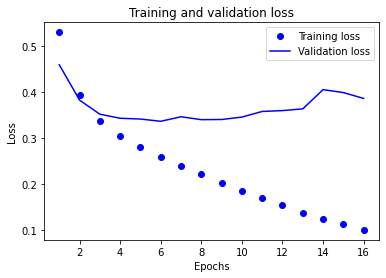

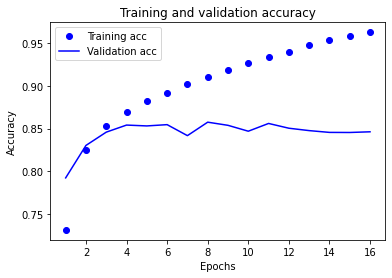

In [92]:
training_visual_fun(model_bi_lstm_gru_history)

## 회고
전처리 부분에 에러가 많이 나서 word2vec 까지 못해봐서 아쉽다. 
끝나고 나서 사전 훈련된 모델인 word2vec과 disti-bert 둘 중에 어느 모델이 성능이 더 좋은지 확인해봐야 겠다. 
https://www.mindscale.kr/course/nlg/72


## 2차 회고

처음에 BERT를 사용하려 했지만 shape 문제로 인해 Bi-LSTM으로 대체하게 됨.
문제를 단순화하는 것이 시간 안에 과제를 끝내는 데 더 좋은 전략이라는 걸 깨담. 처음에는 dropout을 0.5로 설정했는데, 이로 인해 성능이 제한되어 정확도가 84%를 넘지 못했지만 dropout을 0.3으로 줄이자 바로 85%를 넘겼습니다. 
20 에포크로 학습해도 좋은 결과를 얻었지만, early stopping을 사용해 더 빠르게 결과를 확인할 수 있었다.
BERT와의 성능 비교를 계획했지만, 시간이 부족해 중단하게 됨.